In [1]:
import pandas as pd
from preprocessing import get_train_test, set_indexes_for_timeseries,get_weather_forecast
from datetime import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
df_ce = pd.read_csv('dataframes/df_champs_elysees.csv')
df_sts = pd.read_csv('dataframes/df_saints_peres.csv')
df_conv = pd.read_csv('dataframes/df_saints_peres.csv')

In [3]:
df_ce['Date'] = pd.to_datetime(df_ce['Date'])
df_sts['Date'] = pd.to_datetime(df_sts['Date'])
df_conv['Date'] = pd.to_datetime(df_conv['Date'])

df_ce['Date et heure de comptage'] = pd.to_datetime(df_ce['Date et heure de comptage'])
df_sts['Date et heure de comptage'] = pd.to_datetime(df_sts['Date et heure de comptage'])
df_conv['Date et heure de comptage'] = pd.to_datetime(df_conv['Date et heure de comptage'])
#df_sts[['Date et heure de comptage','Date']] = pd.to_datetime(df_sts[['Date et heure de comptage','Date']])
#df_conv[['Date et heure de comptage','Date']] = pd.to_datetime(df_conv[['Date et heure de comptage','Date']])


In [30]:
df_train_ce, df_test_ce = get_train_test(df_ce)
df_train_sts, df_test_sts = get_train_test(df_sts)
df_train_conv, df_test_conv = get_train_test(df_conv)

## Moyenne mobile du débit horaire sur fenêtre de 24h pour l'avenue des champs élysées

In [6]:
df_train_sts = set_indexes_for_timeseries(df_train_sts)

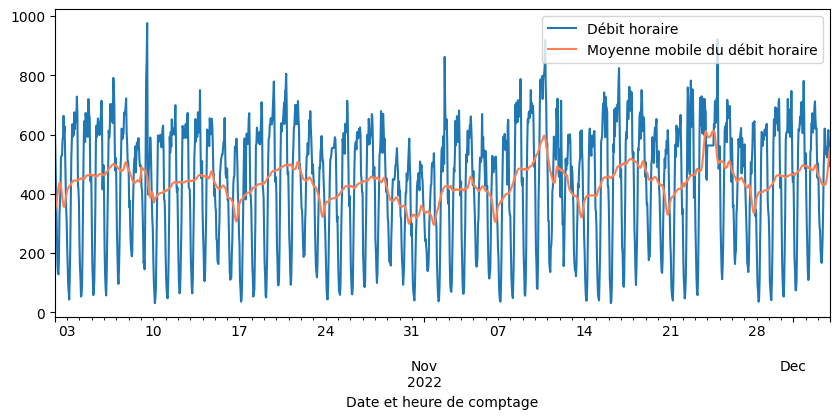

In [7]:

mobile_mean = df_train_sts[df_train_sts["Date"]>datetime(2022,10,1)]["Débit horaire"].dropna().rolling(24, center=True, min_periods=1).mean()
df_train_sts[df_train_sts["Date"]>datetime(2022,10,1)]["Débit horaire"].dropna().plot(figsize=(10,4), label = 'Débit horaire')
mobile_mean.plot(figsize=(10,4), color='coral', label = 'Moyenne mobile du débit horaire')
plt.legend()
plt.show()

## Moyenne mobile du taux d'occupation sur fenêtre de 24h pour l'avenue des champs élysées

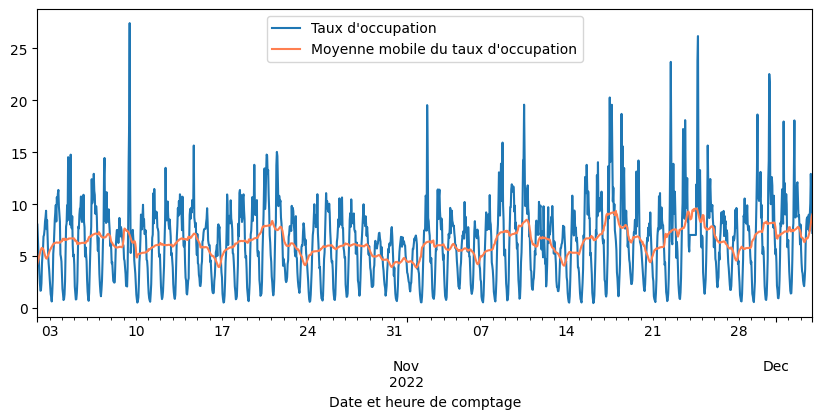

In [8]:

mobile_mean = df_train_sts[df_train_sts["Date"]>datetime(2022,10,1)]["Taux d'occupation"].dropna().rolling(24, center=True, min_periods=1).mean()
df_train_sts[df_train_sts["Date"]>datetime(2022,10,1)]["Taux d'occupation"].dropna().plot(figsize=(10,4), label = "Taux d'occupation")
mobile_mean.plot(figsize=(10,4), color='coral', label = "Moyenne mobile du taux d'occupation")
plt.legend()
plt.show()

## Décomposition saisonnière du débit horaire sur l'avenue des champs élysées

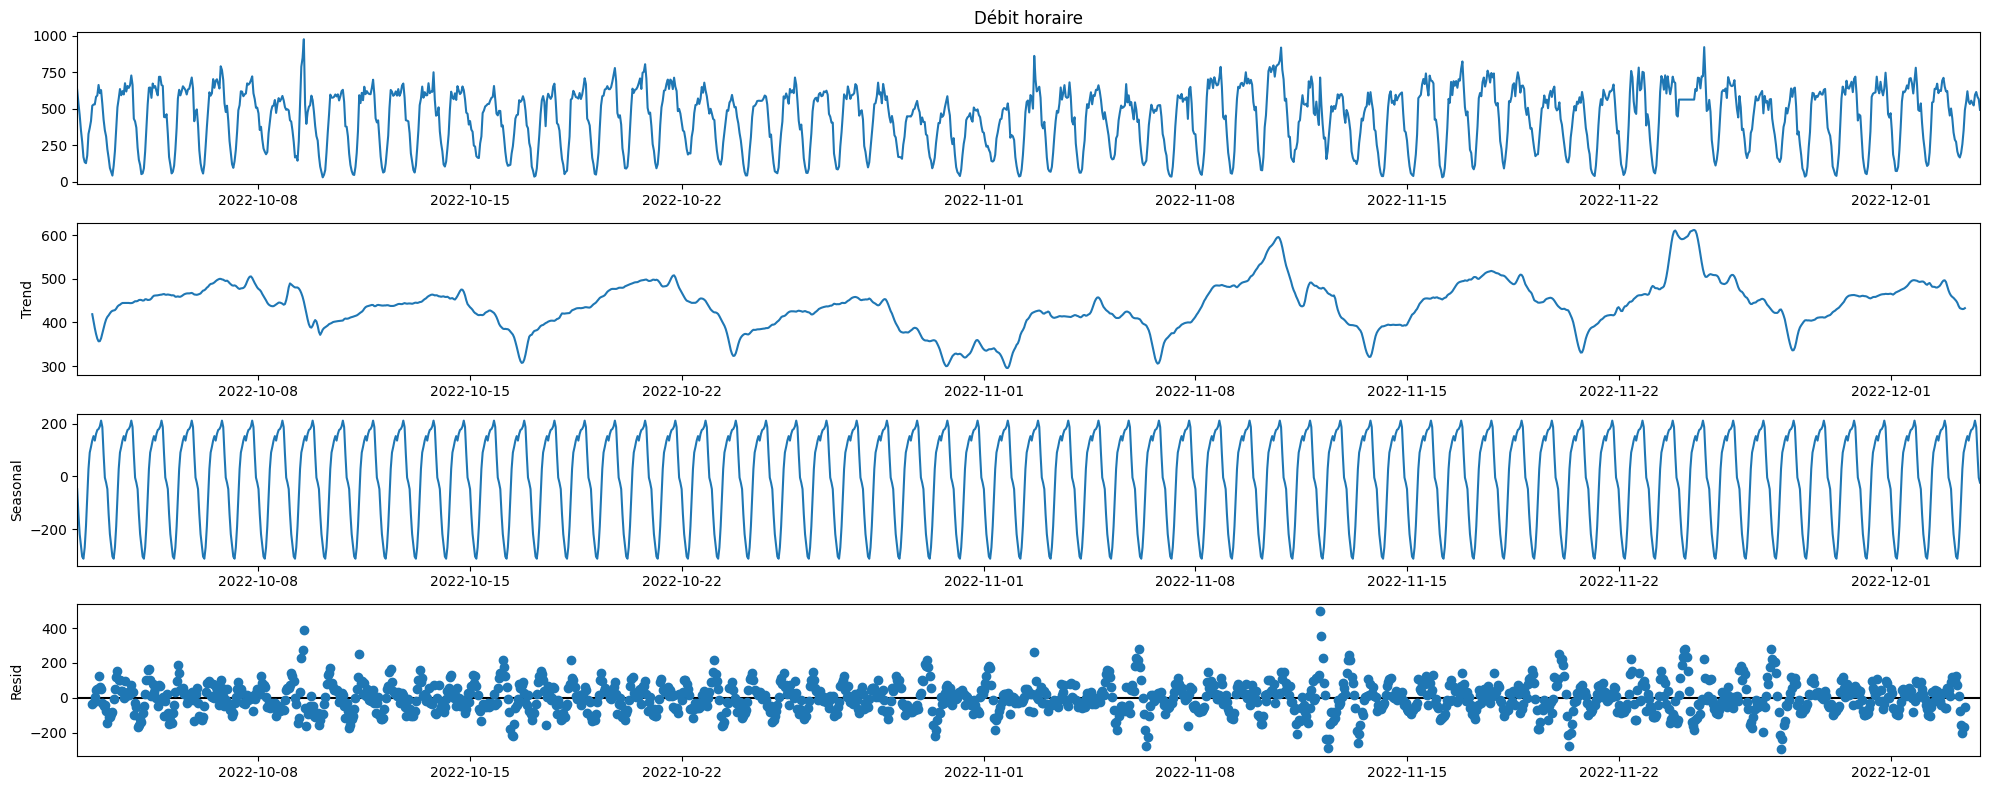

In [9]:

plt.rcParams["figure.figsize"] = (20,8)
decomposition = sm.tsa.seasonal_decompose(df_train_sts[df_train_sts["Date"]>datetime(2022,10,1)]["Débit horaire"].dropna(), model='additive')
fig = decomposition.plot()
plt.show()


Il semble que le débit horaire présente une légère trend et une saisonnalité journalière (période 24 comme nos mesures sont horaires)

/home/romainfournier/.local/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


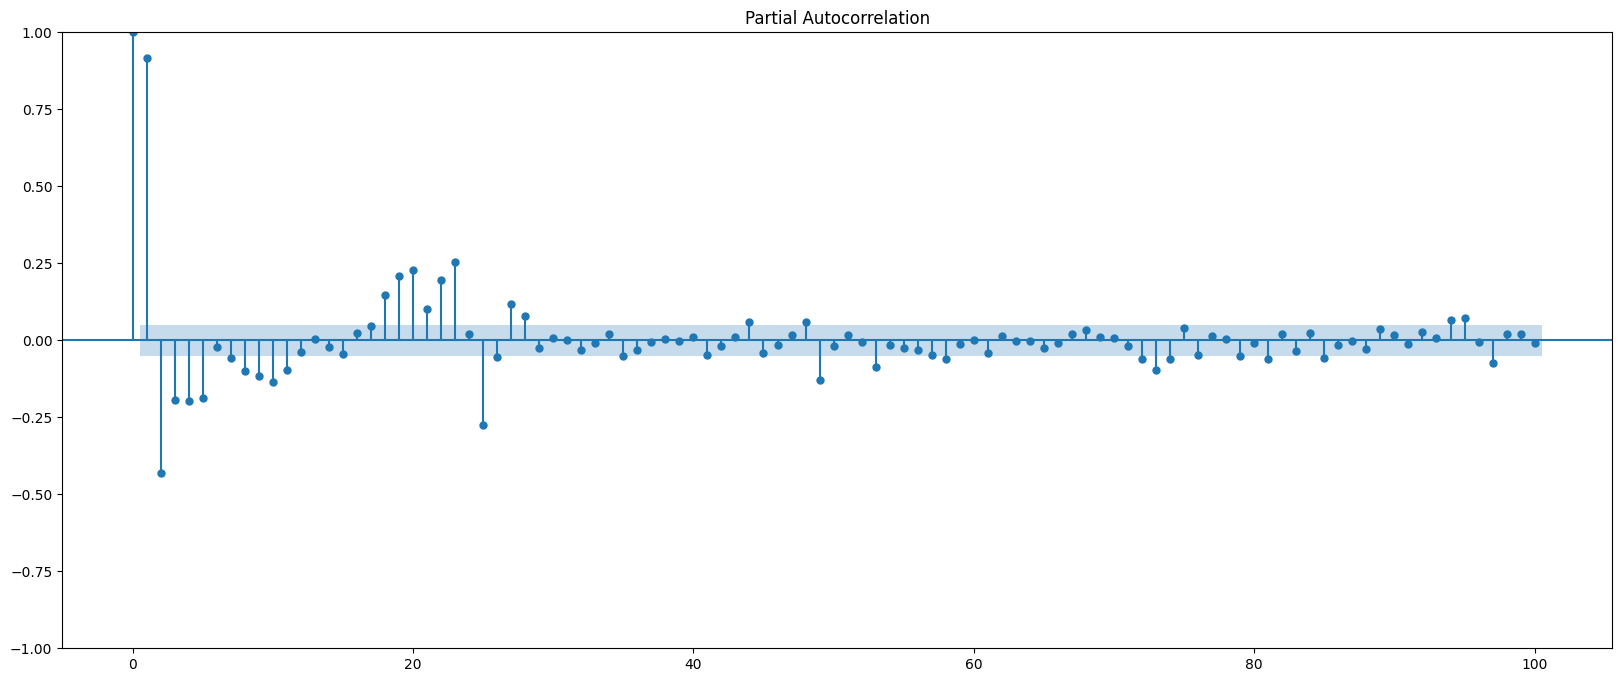

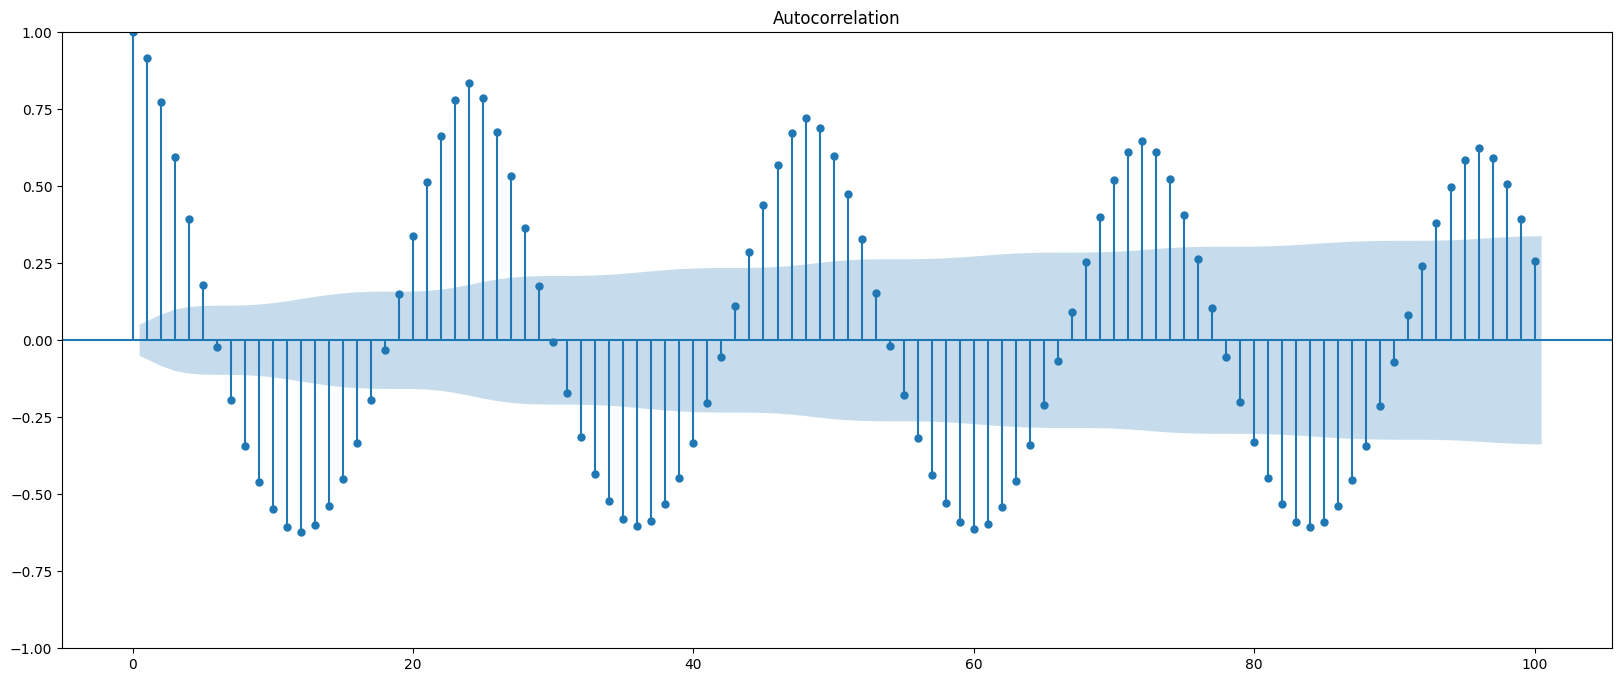

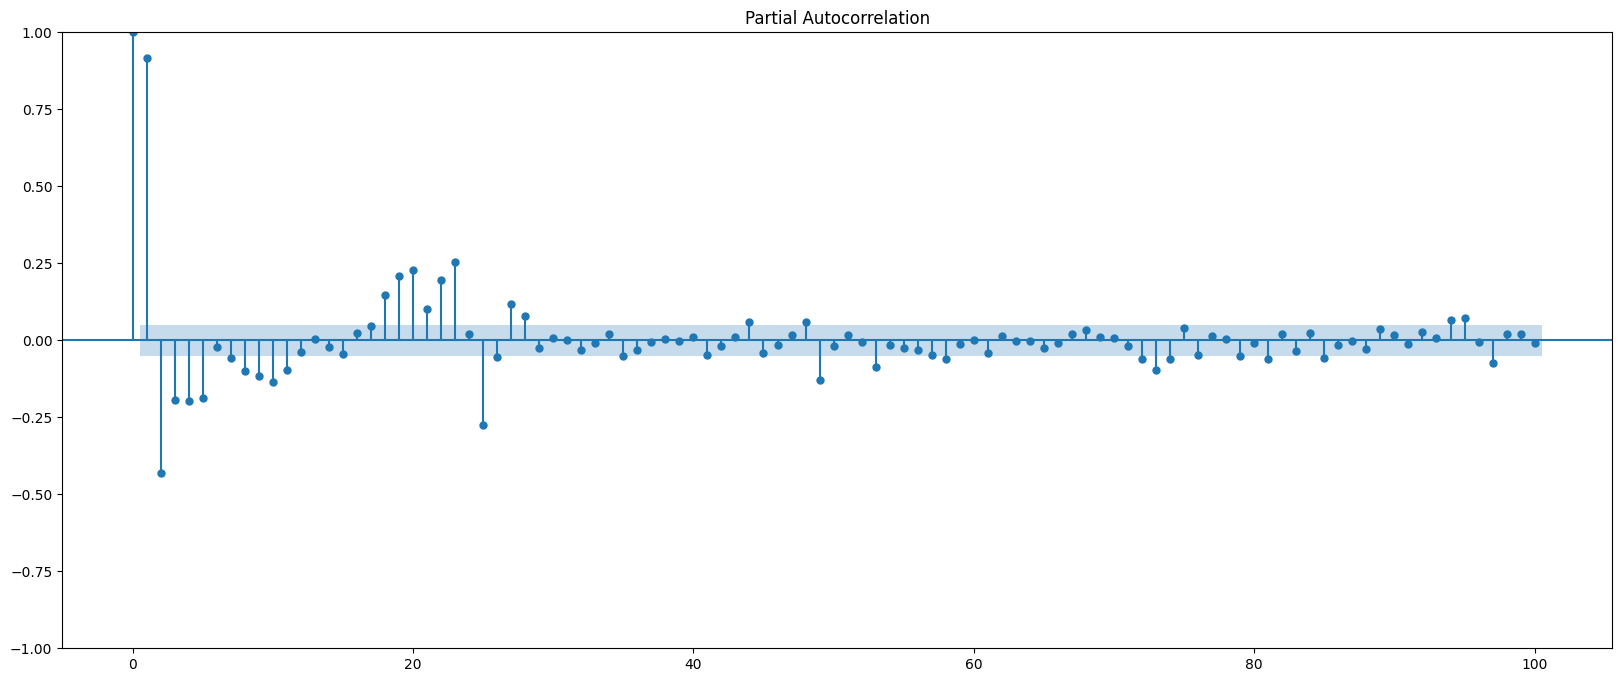

In [10]:
plot_acf(df_train_sts[df_train_sts["Date"]>datetime(2022,10,1)]["Débit horaire"].dropna(),lags=100)
plot_pacf(df_train_sts[df_train_sts["Date"]>datetime(2022,10,1)]["Débit horaire"].dropna(),lags=100)

l'ACF présente des oscillations tantôt positives tantôt négatives ce qui confirme l'hypothèse d'une saisonnalité de période 24.
On n'observe pas de décroissance lente ni rapide de l'ACF donc la série est probablement non stationnaire. On choisit de faire une différenciation saisonnière puis une différenciation simple pour éliminer la trend.

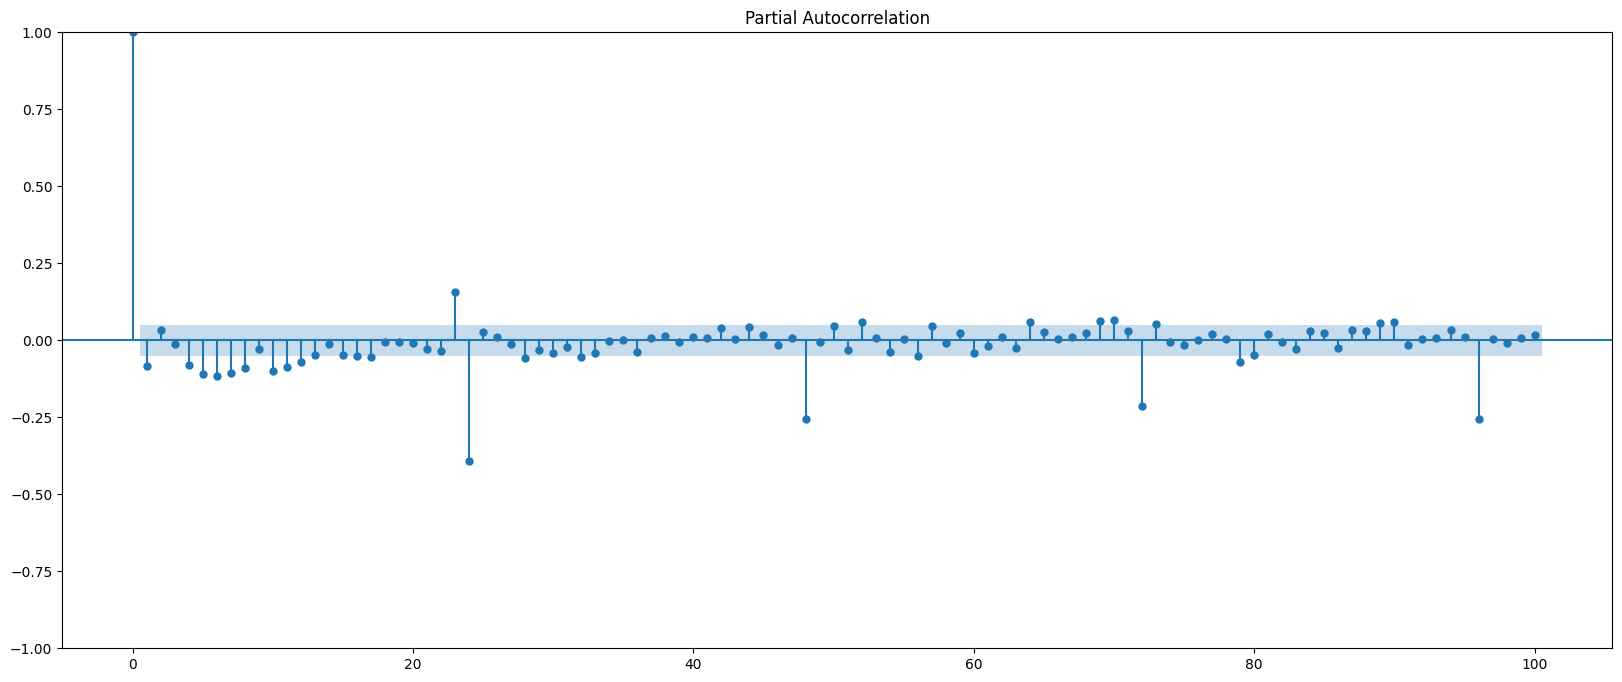

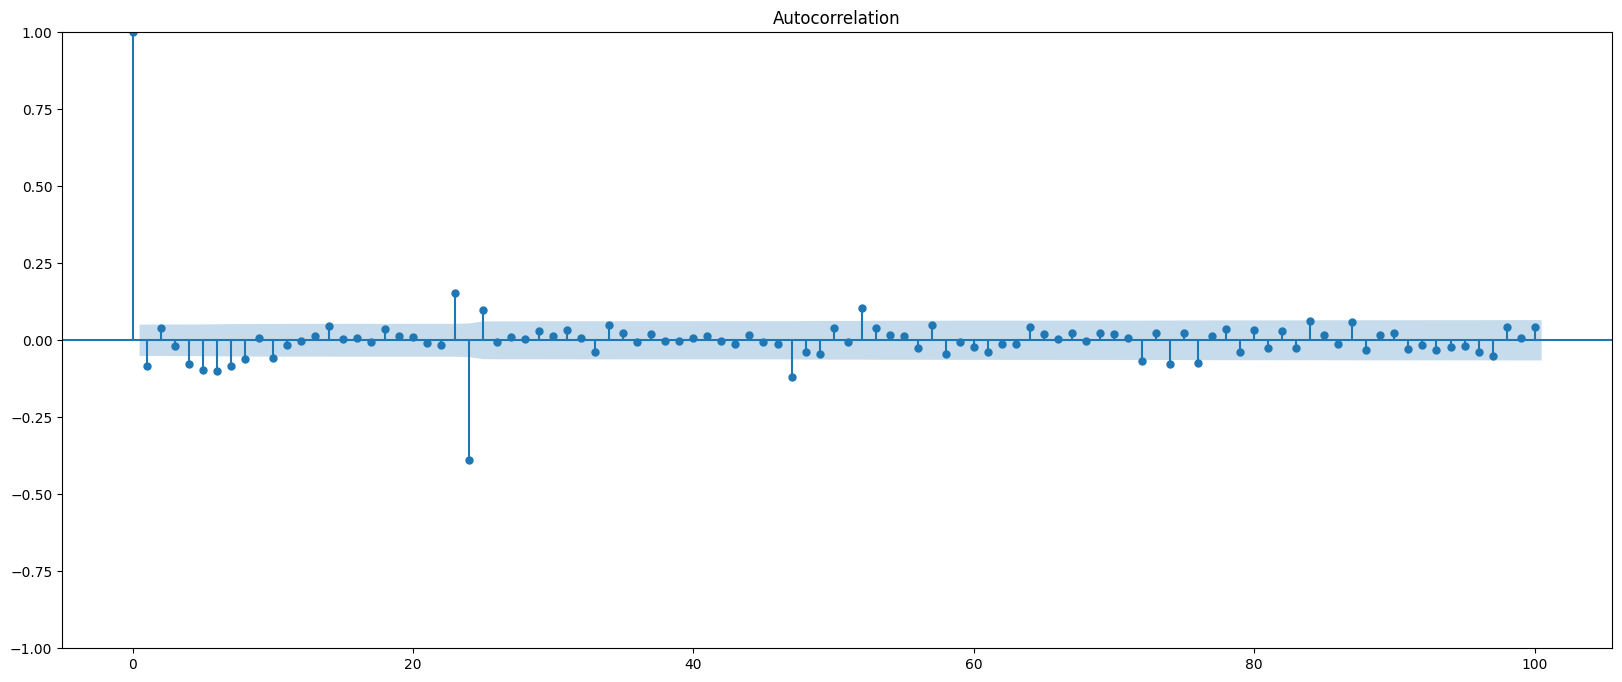

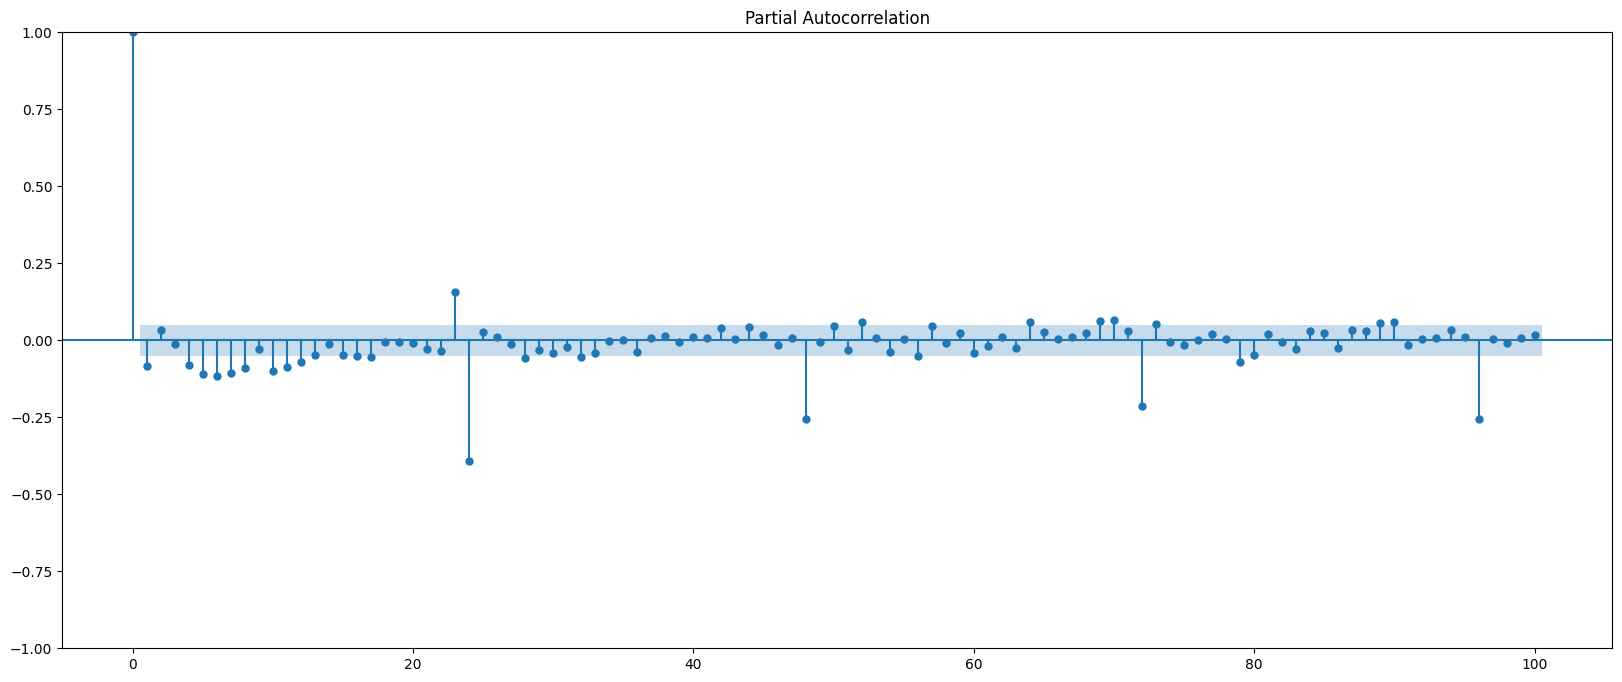

In [11]:
plot_acf(df_train_sts[df_train_sts["Date"]>datetime(2022,10,1)]["Débit horaire"].diff(24).diff().dropna(),lags=100)
plot_pacf(df_train_sts[df_train_sts["Date"]>datetime(2022,10,1)]["Débit horaire"].diff(24).diff().dropna(),lags=100)

- Comme on a effectué une différenciation saisonnière et une différenciation simple, on prend d=1 et D=1
- On prend p = 1 ou 0 car le lag 1 du PACF est significatif mais assez proche de la zone de confiance
- On prend de même q=0 ou 1 car le lag 1 de l'ACF est significatif mais assez proche de la zone de confiance
- On prend P=2 car les lags 24 et 48 du PACF sont significatifs et les lags multiples de 24 suivants sont moins significatifs 
- On prend Q=1 comme le lag de l'ACF est significatif mais pas les suivants

Définissons maintenant les variables exogènes que nous allons utiliser :

In [31]:
df_train_sts = df_train_sts[df_train_sts['cloudcover'].notnull()]

In [32]:
exog_train=df_train_sts[df_train_sts["Date"]>datetime(2022,10,1)]\
[['Jour férié','Vacances scolaires','Jour de la semaine_0','Jour de la semaine_1','Jour de la semaine_2','Jour de la semaine_3',
'Jour de la semaine_4','Jour de la semaine_5','Jour de la semaine_6','Durée avant les prochaines vacances scolaires','tempC','visibility','humidity','precipMM','cloudcover']]

exog_train['Durée avant les prochaines vacances scolaires'] = pd.to_timedelta(exog_train['Durée avant les prochaines vacances scolaires']).dt.days
exog_train = exog_train.astype(float)

In [ ]:
import time
import numpy as np
from sklearn.metrics import mean_squared_error

p=1
d=1
q=0
m=24
P=2
D=1
Q= 1
fitting = True
if fitting:
    s = time.time()
    mod = sm.tsa.statespace.SARIMAX(df_train_sts[df_train_sts["Date"]>datetime(2022,10,1)]["Débit horaire"].dropna(),order=(p,q,d),seasonal_order=(P,D,Q,m),enforce_stationarity=False,enforce_invertibility=False,exog=exog_train)
    model = mod.fit()

/home/romainfournier/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/romainfournier/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.29029D+00    |proj g|=  1.19689D-01

At iterate    5    f=  5.22625D+00    |proj g|=  7.98192D-02


In [15]:
df_train_sts = set_indexes_for_timeseries(df_train_sts)
df_test_sts = set_indexes_for_timeseries(df_test_sts)

In [16]:
a = df_test_sts.index.min()
b = df_test_sts.index.max()
a,b

(Timestamp('2022-12-04 00:00:00', freq='H'),
 Timestamp('2022-12-09 00:00:00', freq='H'))

In [17]:
exog_test=df_test_sts\
[['Jour férié','Vacances scolaires','Jour de la semaine_0','Jour de la semaine_1','Jour de la semaine_2','Jour de la semaine_3',
'Jour de la semaine_4','Jour de la semaine_5','Jour de la semaine_6','Durée avant les prochaines vacances scolaires','tempC','visibility','humidity','cloudcover','precipMM']]

exog_test['Durée avant les prochaines vacances scolaires'] = pd.to_timedelta(exog_test['Durée avant les prochaines vacances scolaires']).dt.days
exog_test = exog_test.astype(float)

/tmp/ipykernel_1061/2734322352.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exog_test['Durée avant les prochaines vacances scolaires'] = pd.to_timedelta(exog_test['Durée avant les prochaines vacances scolaires']).dt.days


In [18]:
pred = model.predict(start=a,end=b,exog=exog_test)
pred_train = model.predict(start=df_train_sts[df_train_sts["Date"]>datetime(2022,10,1)].index.min(),
                           end=df_train_sts[df_train_sts["Date"]>datetime(2022,10,1)].index.max(),exog=exog_train)

rmse = round(np.sqrt(mean_squared_error(df_test_sts["Débit horaire"], pred)),1)
print(rmse)
plt.plot(df_train_ce[df_train_sts["Date"]>datetime(2022,10,1).date()]["Débit horaire"], label='Données')
plt.plot(df_test_sts["Débit horaire"], "--",  label='Target')
plt.plot(pred, label='Prediction')
plt.plot(pred_train, label = 'Prediction train')
plt.xticks(rotation=45)
plt.title(f'Predictions pour Champs Élysées du 4 décembre au 9 décembre 2022 \n RMSE={rmse}')
plt.legend()
plt.show()


MissingDataError: exog contains inf or nans

In [33]:
exog_test.isna().sum()

Jour férié                                         0
Vacances scolaires                                 0
Jour de la semaine_0                               0
Jour de la semaine_1                               0
Jour de la semaine_2                               0
Jour de la semaine_3                               0
Jour de la semaine_4                               0
Jour de la semaine_5                               0
Jour de la semaine_6                               0
Durée avant les prochaines vacances scolaires      0
tempC                                            120
visibility                                       120
humidity                                         120
cloudcover                                       120
precipMM                                         120
dtype: int64